<a href="https://colab.research.google.com/github/badasqi/LR_EDB/blob/main/LR2_EDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Корпоративные базы данных
##  Гусев И.А. - 6133-010402D.  Лабораторная работа №2.

## Подключаем гугл диск

In [1]:
#подключаем гугл диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка датасета и разбиение на тренировочный и тестовый набор данных

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import itertools
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_csv('/content/drive/MyDrive/sales_by_gender.csv')

# Удаление строк, где amount_sold и total_price равны 0
data = data[(data['amount_sold'] != 0) & (data['total_price'] != 0)]

# Подготовка данных
X = data.drop(columns=['product_name', 'amount_sold'])  # Признаки
y = data['amount_sold']  # Метка

# Кодирование категориальных признаков
label_encoders = {}
for col in ['product_category', 'gender']:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col]) % 100 # т.к у нас 100 категорий

# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Архитектура НС
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len(X[0]), 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Функция для обучения модели и оценки ее производительности
def train_and_evaluate(params):
    net = Net().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=params['lr'])

    for epoch in range(params['epochs']):
        optimizer.zero_grad()
        outputs = net(X_train_tensor)
        loss = criterion(outputs.view(-1), y_train_tensor)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        net.eval()
        predictions = net(X_test_tensor)
        predictions_np = predictions.cpu().numpy().flatten()
        real_values_np = y_test_tensor.cpu().numpy().flatten()
        mae = mean_absolute_error(real_values_np, predictions_np)
        r2 = r2_score(real_values_np, predictions_np)

    return mae, r2

# Параметры для перебора
epoch_grid = [100, 200, 500, 700, 1000, 1500]
lr_grid = [0.0001, 0.001, 0.01, 0.05, 0.1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)


## Поиск наилучших параметров для разного количества эпох

Параметры: {'lr': 0.001, 'epochs': 100}, MAE: 14.9646, R2: -0.2612
Параметры: {'lr': 0.001, 'epochs': 200}, MAE: 11.0474, R2: 0.4302
Параметры: {'lr': 0.001, 'epochs': 500}, MAE: 10.6590, R2: 0.4526
Параметры: {'lr': 0.001, 'epochs': 700}, MAE: 10.5525, R2: 0.4586
Параметры: {'lr': 0.001, 'epochs': 1000}, MAE: 10.5484, R2: 0.4595
Параметры: {'lr': 0.001, 'epochs': 1500}, MAE: 10.5491, R2: 0.4600


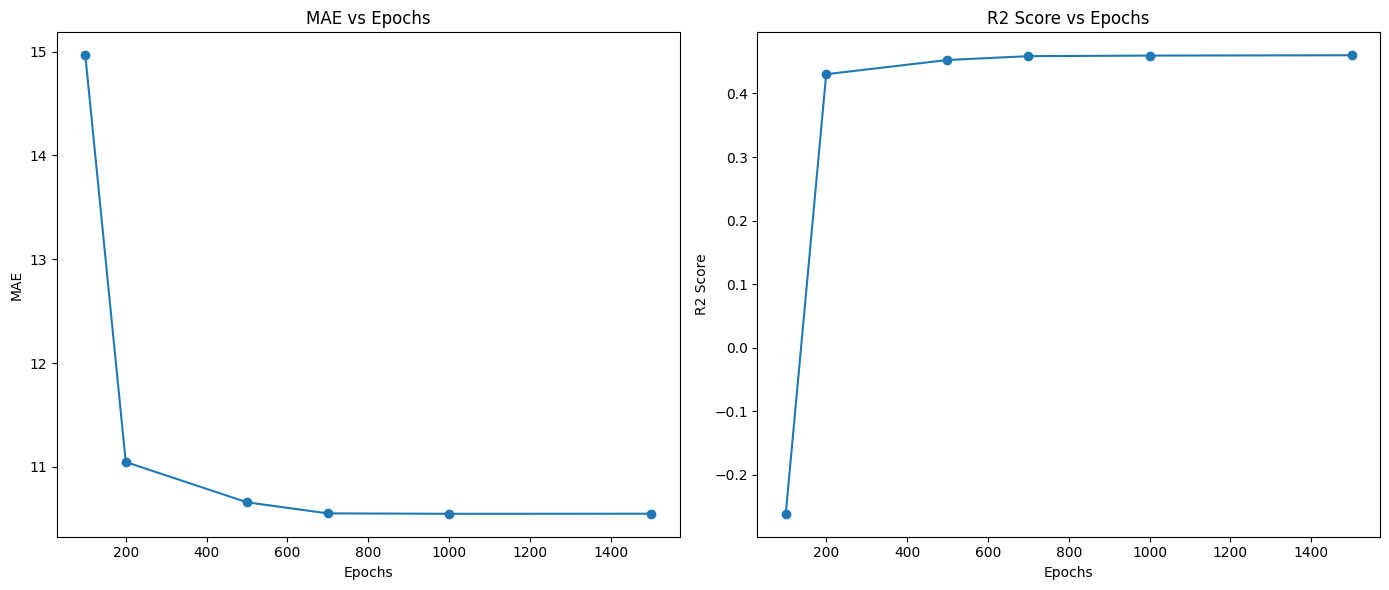

Наилучшие параметры для Epochs: {'lr': 0.001, 'epochs': 1000}
Лучший MAE: 10.5484, Лучший R2: 0.4595


In [29]:
# Поиск наилучших параметров для разных epochs
results_epochs = []
best_epoch_params = None
best_epoch_mae = float('inf')
best_epoch_r2 = -float('inf')

for epochs in epoch_grid:
    current_params = {'lr': 0.001, 'epochs': epochs}  # lr зафиксирован на 0.001
    mae, r2 = train_and_evaluate(current_params)
    results_epochs.append((epochs, mae, r2))
    print(f"Параметры: {current_params}, MAE: {mae:.4f}, R2: {r2:.4f}")

    if mae < best_epoch_mae:
        best_epoch_mae = mae
        best_epoch_r2 = r2
        best_epoch_params = current_params

# Построение графика для epochs
epochs = [result[0] for result in results_epochs]
maes_epochs = [result[1] for result in results_epochs]
r2s_epochs = [result[2] for result in results_epochs]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, maes_epochs, marker='o')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('MAE vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, r2s_epochs, marker='o')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.title('R2 Score vs Epochs')

plt.tight_layout()
plt.show()

print("Наилучшие параметры для Epochs:", best_epoch_params)
print(f"Лучший MAE: {best_epoch_mae:.4f}, Лучший R2: {best_epoch_r2:.4f}")

## Построение графика для различных learning rate

Параметры: {'lr': 0.0001, 'epochs': 1000}, MAE: 13.7064, R2: -0.0693
Параметры: {'lr': 0.001, 'epochs': 1000}, MAE: 10.5820, R2: 0.4585
Параметры: {'lr': 0.01, 'epochs': 1000}, MAE: 10.5130, R2: 0.4616
Параметры: {'lr': 0.05, 'epochs': 1000}, MAE: 10.5284, R2: 0.4616
Параметры: {'lr': 0.1, 'epochs': 1000}, MAE: 10.5253, R2: 0.4619


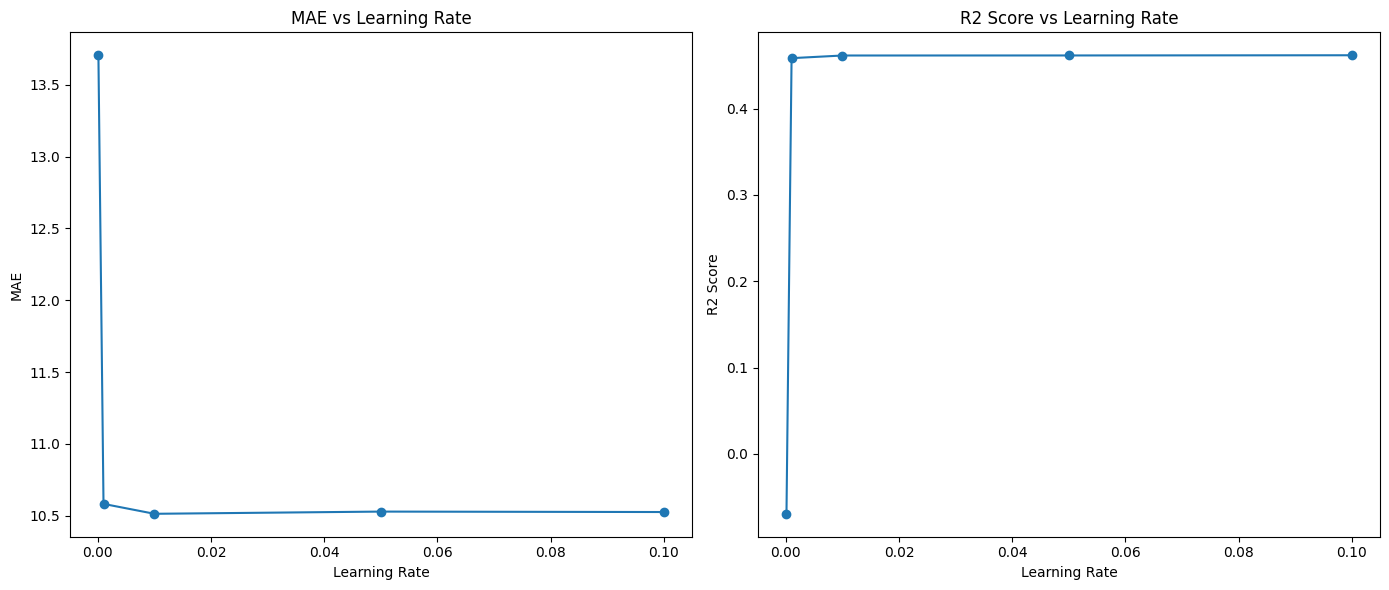

Наилучшие параметры для Learning Rate: {'lr': 0.01, 'epochs': 1000}
Лучший MAE: 10.5130, Лучший R2: 0.4616


In [30]:
# Поиск наилучших параметров для learning rate
results_lr = []
best_lr_params = None
best_lr_mae = float('inf')
best_lr_r2 = -float('inf')

for lr in lr_grid:
    current_params = {'lr': lr, 'epochs': best_epoch_params['epochs']}  # epochs зафиксированы на лучшем значении
    mae, r2 = train_and_evaluate(current_params)
    results_lr.append((lr, mae, r2))
    print(f"Параметры: {current_params}, MAE: {mae:.4f}, R2: {r2:.4f}")

    if mae < best_lr_mae:
        best_lr_mae = mae
        best_lr_r2 = r2
        best_lr_params = current_params

# Построение графика для learning rate
lrs = [result[0] for result in results_lr]
maes_lr = [result[1] for result in results_lr]
r2s_lr = [result[2] for result in results_lr]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(lrs, maes_lr, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('MAE')
plt.title('MAE vs Learning Rate')

plt.subplot(1, 2, 2)
plt.plot(lrs, r2s_lr, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('R2 Score')
plt.title('R2 Score vs Learning Rate')

plt.tight_layout()
plt.show()

print("Наилучшие параметры для Learning Rate:", best_lr_params)
print(f"Лучший MAE: {best_lr_mae:.4f}, Лучший R2: {best_lr_r2:.4f}")

## Обучение модели с лучшими параметрами

In [31]:
final_net = Net().to(device)
final_optimizer = optim.Adam(final_net.parameters(), lr=best_lr_params['lr'])

for epoch in range(best_lr_params['epochs']):
    final_optimizer.zero_grad()
    outputs = final_net(X_train_tensor)
    loss = criterion(outputs.view(-1), y_train_tensor)
    loss.backward()
    final_optimizer.step()

# Сохранение лучшей модели
torch.save(final_net.state_dict(), 'best_NN_model_predict_amount_sales')

# Оценка производительности лучшей модели
with torch.no_grad():
    final_net.eval()
    final_predictions = final_net(X_test_tensor)
    final_predictions_np = final_predictions.cpu().numpy().flatten()
    final_real_values_np = y_test_tensor.cpu().numpy().flatten()
    final_mae = mean_absolute_error(final_real_values_np, final_predictions_np)
    final_r2 = r2_score(final_real_values_np, final_predictions_np)

print(f"Итоговый MAE: {final_mae:.4f}, Итоговый R2: {final_r2:.4f}")

# Вывод нескольких предсказанных и реальных значений
print("Предсказанные значения vs. Реальные значения:")
for i in range(50):
    print(f"Предсказанное значение: {final_predictions_np[i]}, Реальное значение: {final_real_values_np[i]}")

Итоговый MAE: 10.5411, Итоговый R2: 0.4609
Предсказанные значения vs. Реальные значения:
Предсказанное значение: 20.984010696411133, Реальное значение: 24.0
Предсказанное значение: 27.455581665039062, Реальное значение: 9.0
Предсказанное значение: 24.250638961791992, Реальное значение: 39.0
Предсказанное значение: 14.214273452758789, Реальное значение: 7.0
Предсказанное значение: 20.18303680419922, Реальное значение: 21.0
Предсказанное значение: 23.208908081054688, Реальное значение: 14.0
Предсказанное значение: 27.639909744262695, Реальное значение: 9.0
Предсказанное значение: 76.5710678100586, Реальное значение: 58.0
Предсказанное значение: 18.808795928955078, Реальное значение: 26.0
Предсказанное значение: 19.974796295166016, Реальное значение: 45.0
Предсказанное значение: 45.26229476928711, Реальное значение: 34.0
Предсказанное значение: 18.299863815307617, Реальное значение: 20.0
Предсказанное значение: 38.60517883300781, Реальное значение: 59.0
Предсказанное значение: 53.56102752